### Look at the weights for confidence decoders
- What is across time-bin cosine similarity for decoder weights in the overall confidence decoder? 
- What about for preferred feature decoder? 
- What does cosine similarity look like between confidence weights and preferred feature decoder weights?

In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *

import seaborn as sns
import scipy


### Load things

In [3]:
PRE_INTERVAL = 1000
POST_INTERVAL = 1000
INTERVAL_SIZE = 100
SMOOTH = 1
EVENT = "StimOnset"

# EVENT = "FeedbackOnset"  # event in behavior to align on
# PRE_INTERVAL = 1300   # time in ms before event
# POST_INTERVAL = 1500  # time in ms after event
# INTERVAL_SIZE = 100  # size of interval in ms

OUTPUT_DIR = "/data/patrick_res/hyak/pseudo"
# path to a dataframe of sessions to analyze
pairs = pd.read_pickle("/data/patrick_res/sessions/pairs_at_least_3blocks_7sess.pickle")

In [19]:
def cross_cosine_sim(weights):
    """
    Takes in weights [num_time_bins, num_units]
    Returns cross cosine similarity, [num_time_bins, num_time_bins]
    """
    cross_sim = np.empty((weights.shape[0], weights.shape[0]))
    for i in range(weights.shape[0]):
        for j in range(weights.shape[0]):
            cross_sim[i, j] = np.dot(weights[i, :], weights[j, :]) / (np.linalg.norm(weights[i, :]) * np.linalg.norm(weights[j, :]))
    return cross_sim

def between_cosine_sim(weights_a, weights_b):
    """
    Takes in two sets of weights [num_time_bins, num_units]
    returns cos similarity between the two sets of weights, [num_time_bins]
    """
    between_sim = np.empty((weights_a.shape[0]))
    for i in range(weights_a.shape[0]):
        between_sim[i] = np.dot(weights_a[i, :], weights_b[i, :]) / (np.linalg.norm(weights_a[i, :]) * np.linalg.norm(weights_b[i, :]))
    return between_sim


### Cross for confidence

In [15]:
all_crosses = np.empty((20, 20, len(pairs.pair.values)))
for i, (feat1, feat2) in enumerate(pairs.pair.values):
    models = np.load(os.path.join(OUTPUT_DIR, f"confidence_overall_StimOnset_pair_{feat1}_{feat2}_models.npy"), allow_pickle=True)
    weights = classifier_utils.evaluate_model_weight_diffs(models)
    avg_weights = np.mean(weights, axis=1)
    crosses = cross_cosine_sim(avg_weights)
    all_crosses[:, :, i] = crosses

In [17]:
avg_crosses = np.mean(all_crosses, axis=2)

Text(0.5, 1.0, 'Cross cosine sim for confidence')

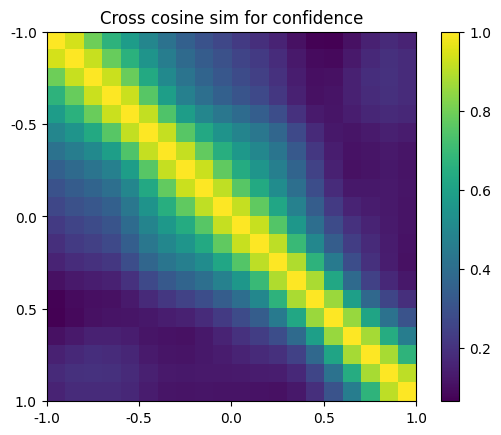

In [27]:
fig, ax = plt.subplots()
colors = ax.matshow(avg_crosses)
fig.colorbar(colors)
ratio = 1000 / INTERVAL_SIZE
tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0])
tick_pos = (tick_labels + 1) * ratio - 0.5

# tick_labels = np.arange(len(cross_accs))
# tick_pos = np.arange(len(cross_accs))
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels)
ax.xaxis.tick_bottom()

ax.set_yticks(tick_pos)
ax.set_yticklabels(tick_labels)
ax.set_title("Cross cosine sim for confidence")

### Cross for preferred features

In [28]:
all_crosses = np.empty((20, 20, len(pairs.pair.values)))
for i, (feat1, feat2) in enumerate(pairs.pair.values):
    models = np.load(os.path.join(OUTPUT_DIR, f"high_conf_fixed_max_feat_by_pairs_{EVENT}_pair_{feat1}_{feat2}_models.npy"), allow_pickle=True)
    weights = classifier_utils.evaluate_model_weight_diffs(models)
    avg_weights = np.mean(weights, axis=1)
    crosses = cross_cosine_sim(avg_weights)
    all_crosses[:, :, i] = crosses
avg_crosses = np.mean(all_crosses, axis=2)


Text(0.5, 1.0, 'Cross cosine sim for confidence')

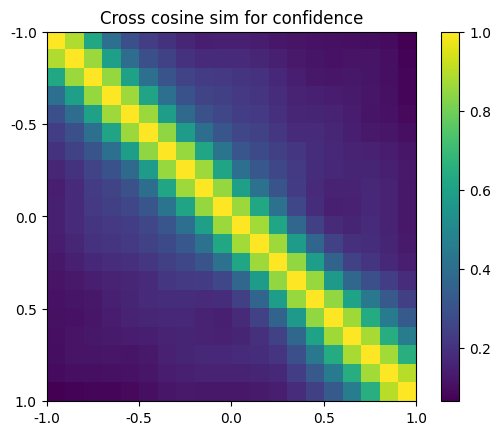

In [29]:
fig, ax = plt.subplots()
colors = ax.matshow(avg_crosses)
fig.colorbar(colors)
ratio = 1000 / INTERVAL_SIZE
tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0])
tick_pos = (tick_labels + 1) * ratio - 0.5

# tick_labels = np.arange(len(cross_accs))
# tick_pos = np.arange(len(cross_accs))
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels)
ax.xaxis.tick_bottom()

ax.set_yticks(tick_pos)
ax.set_yticklabels(tick_labels)
ax.set_title("Cross cosine sim for confidence")

### Cosine sim between conf and preferred features

In [20]:
all_betweens = np.empty((20, len(pairs.pair.values)))
for i, (feat1, feat2) in enumerate(pairs.pair.values):
    conf_models = np.load(os.path.join(OUTPUT_DIR, f"confidence_overall_StimOnset_pair_{feat1}_{feat2}_models.npy"), allow_pickle=True)
    pref_models = np.load(os.path.join(OUTPUT_DIR, f"high_conf_fixed_max_feat_by_pairs_{EVENT}_pair_{feat1}_{feat2}_models.npy"), allow_pickle=True)
    avg_conf_weights = np.mean(classifier_utils.evaluate_model_weight_diffs(conf_models), axis=1)
    avg_pref_weights = np.mean(classifier_utils.evaluate_model_weight_diffs(pref_models), axis=1)
    all_betweens[:, i] = between_cosine_sim(avg_conf_weights, avg_pref_weights)

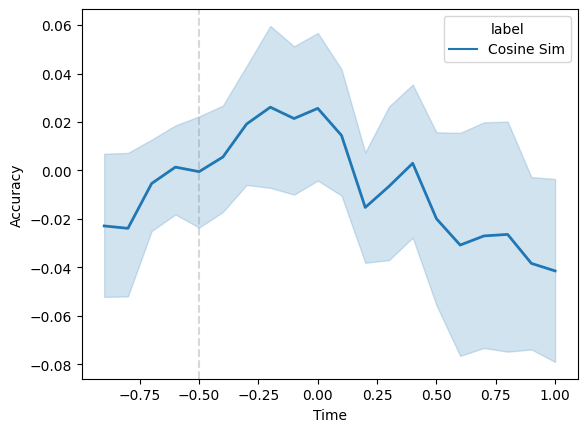

In [22]:
fig, ax = plt.subplots()
visualization_utils.plot_accs_seaborn(
    [all_betweens], 
    ["Cosine Sim"], 
    PRE_INTERVAL, INTERVAL_SIZE, ax)
ax.axvline(-0.5, alpha=0.3, color='gray', linestyle='dashed', label="Cross Fixation")